In [79]:
import pandas as pd

all = pd.read_csv('all_lat.csv', index_col=False)
# 移除土地與車位
all = all [all ['交易標的'] != '土地']
all = all[all['交易標的'] != '車位']
all = all[all['交易年月日']>= 1060101]

c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
NA_columns = all.columns[all.isna().any()].tolist()
all[NA_columns].isnull().sum()

都市土地使用分區      2647
非都市土地使用分區    47955
非都市土地使用編定    47955
移轉層次           117
總樓層數            87
主要用途            78
主要建材            69
建築完成年月        1814
單價元/平方公尺       230
車位類別         25475
備註           30207
lat             24
lng             24
dtype: int64

> https://drive.google.com/open?id=1raKuQ5sQvNMg-N0riEuDo9IpavoTjXCaSZLSLntE4Eo

In [80]:
# 補齊沒車位的
all['車位類別'] = all['車位類別'].fillna('無')
all['都市土地使用分區'] = all['都市土地使用分區'].fillna('非')
all['主要建材'] = all['主要建材'].fillna('others')
all['主要用途'] = all['主要用途'].fillna('others')

In [81]:
all['建築完成年月'] = all['建築完成年月'].replace(regex=[r'\/'],value=0)
all['建築完成年月'] = all['建築完成年月'].fillna(0).astype('int64')
all['屋齡'] = (all['交易年月日']//10000-all['建築完成年月']//10000)
all['屋齡'] = all['屋齡'].replace(all[all['建築完成年月']==0]['屋齡'],value=0)
all['屋齡'] = all['屋齡'].replace(all[all['建築完成年月']<10000]['屋齡'],value=30)

In [82]:
cols = '土地 建物 車位'.split()
all[cols] = all['交易筆棟數'].str.extract(r'\D+(\d+)\D+(\d+)\D+(\d+)', expand=True)
all.columns

Index(['鄉鎮市區', '交易標的', '土地區段位置/建物區段門牌', '土地移轉總面積平方公尺', '都市土地使用分區', '非都市土地使用分區',
       '非都市土地使用編定', '交易年月日', '交易筆棟數', '移轉層次', '總樓層數', '建物型態', '主要用途', '主要建材',
       '建築完成年月', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛',
       '建物現況格局-隔間', '有無管理組織', '總價元', '單價元/平方公尺', '車位類別', '車位移轉總面積平方公尺',
       '車位總價元', '備註', '編號', 'lat', 'lng', '屋齡', '土地', '建物', '車位'],
      dtype='object')

In [83]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
# feature = ohe.fit_transform(all[['鄉鎮市區', '都市土地使用分區', '車位類別', '建物現況格局-隔間', '有無管理組織', '主要建材','主要用途']]).toarray()
feature = ohe.fit_transform(all[['鄉鎮市區', '都市土地使用分區']]).toarray()
feature = pd.DataFrame(feature)
# 108年度(全部資料)多一類
# feature[34] = 0
feature.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [128]:
target = all['總價元']
# num_feature = all[['建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', '建物移轉總面積平方公尺', 'lat', 'lng', '屋齡', '土地', '建物', '車位']].copy()
num_feature = all[['建物移轉總面積平方公尺', '建物', '屋齡', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']].copy()

### 處理樓層

In [105]:
# 移轉樓層比例 
floor = pd.read_csv('../0704/floor_feature.csv', index_col=False)
add_floor = pd.concat([all, floor], axis=1)
add_floor.head()

,鄉鎮市區,交易標的,土地區段位置/建物區段門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,...,編號,lat,lng,屋齡,土地,建物,車位,移轉層次(正數),移轉層次(非正數),移轉層次(非純數)
0,板橋區,房地(土地+建物),新北市板橋區華東街271~300號,8.80,住,NaN,NaN,1060621.0,土地2建物1車位0,十九層,...,RPUOMLMJQHMFFAF48CA,25.001936,121.452653,1.0,2,1,0,0.791667,0.0,NaN
1,板橋區,房地(土地+建物)+車位,新北市板橋區華東街271~300號,18.48,住,NaN,NaN,1060725.0,土地2建物1車位1,十八層,...,RPXOMLMJQHMFFAF78CA,25.001936,121.452653,1.0,2,1,1,0.750000,0.0,NaN
2,土城區,房地(土地+建物),新北市土城區永豐路121~150號,17.71,住,NaN,NaN,1060617.0,土地6建物1車位0,九層,...,RPORMLMJQHMFFAF18CA,24.984078,121.466060,22.0,6,1,0,0.642857,0.0,NaN
3,板橋區,房地(土地+建物)+車位,新北市板橋區新崑路91~120號,26.23,住,NaN,NaN,1060630.0,土地1建物1車位1,八層,...,RPQNMLNJQHMFFAF08CA,24.999177,121.432317,1.0,1,1,1,0.615385,0.0,NaN
4,土城區,房地(土地+建物),新北市土城區延和路76巷1~30號,22.47,住,NaN,NaN,1060620.0,土地1建物1車位0,一層,...,RPSOMLNJQHMFFAF38CA,24.989084,121.466463,36.0,1,1,0,0.200000,0.0,NaN


### Normalization

In [129]:
# 標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
scaler = StandardScaler()
num_feature['樓層'] = add_floor['移轉層次(正數)'].copy()
num_feature['建物移轉總面積平方公尺']  = num_feature['建物移轉總面積平方公尺'] / all['建物'].astype(int)
num_feature[['建物移轉總面積平方公尺', '樓層']] = scaler.fit_transform(num_feature[['建物移轉總面積平方公尺', '樓層']])
# scaler = QuantileTransformer()
# num_feature[['lat', 'lng']] = scaler.fit_transform(num_feature[['lat', 'lng']])
num_feature = num_feature.reset_index().drop('index', axis=1)

> https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows

In [130]:
features = pd.concat([num_feature, feature], axis=1)
print(num_feature.shape)
print(feature.shape)
print(features.shape)

(50401, 7)
(50401, 34)
(50401, 41)


### Model

In [131]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(1024, input_dim=features.columns.size, activation='relu', name='dense1'))
model.add(Dense(512, name='dense2', activation='relu'))
model.add(Dense(64, name='dense3', activation='relu'))
model.add(Dense(64, name='dense4', activation='relu'))
model.add(Dense(32, name='dense5', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='relu', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1024)              43008     
_________________________________________________________________
dense2 (Dense)               (None, 512)               524800    
_________________________________________________________________
dense3 (Dense)               (None, 64)                32832     
_________________________________________________________________
dense4 (Dense)               (None, 64)                4160      
_________________________________________________________________
dense5 (Dense)               (None, 32)                2080      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 33        
Total params: 606,913
Trainable params: 606,913
Non-trainable params: 0
_________________________________________________________________


> https://zhuanlan.zhihu.com/p/34667893

In [132]:
from keras import backend as K
def mean_absolute_percentage_error(y_true, y_pred):
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(x=features, y=target, validation_split=0.2, epochs=300, batch_size=500, verbose=0)

### Plot

In [77]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc], color='green')
    plt.plot(train_history.history[test_acc], color='cyan')
    plt.title('Train History')
    plt.ylabel(train_acc)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

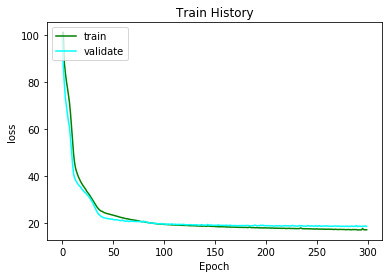

In [133]:
show_train_history('loss', 'val_loss')

| Model | 特徵 | MAPE |
| --- | --- | --- |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區 | 27% |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡 | 21% |
| output = Linear | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡 | 22% |
| output = Linear | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡, 車位 | 20% |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡, 車位 | 20% |
| output = ReLU | 建物移轉總面積, 建物, 鄉鎮市區, 屋齡,都市土地使用分區 | 19% |

In [116]:
testDF = pd.DataFrame()

for i in range(1, 4):
    try:
        temp = pd.read_csv('./test_data/108_S' + str(i) + '_F_lvr_land_A.csv', header=None)
        col_list= temp.iloc[0].values
        temp = temp.drop(temp.index[[0, 1]])
        testDF = pd.concat([testDF, temp], axis=0)
    except Exception as e:
        print(e)
        continue

testDF.columns = col_list
print(testDF.shape)
print(testDF[testDF.columns[testDF.isna().any()].tolist()].isnull().sum())

(26345, 28)
都市土地使用分區      1742
非都市土地使用分區    24785
非都市土地使用編定    24792
移轉層次          3268
總樓層數          3271
主要用途          3276
主要建材          3269
建築完成年月        4022
單價元平方公尺        907
車位類別         13595
備註           15948
dtype: int64


In [119]:
testDF.to_csv('./test_data/all_test.csv', index=False, encoding='utf_8_sig')

In [120]:
testDF = pd.read_csv('./test_data/all_test.csv', index_col=False)
testDF['都市土地使用分區'] = testDF['都市土地使用分區'].fillna('非')
testDF['建築完成年月'] = testDF['建築完成年月'].replace(regex=[r'\/'],value=0)
testDF['建築完成年月'] = testDF['建築完成年月'].fillna(0).astype('int64')
testDF['屋齡'] = (testDF['交易年月日']//10000-testDF['建築完成年月']//10000)
testDF['屋齡'] = testDF['屋齡'].replace(testDF[testDF['建築完成年月']==0]['屋齡'],value=0)
testDF['屋齡'] = testDF['屋齡'].replace(testDF[testDF['建築完成年月']<10000]['屋齡'],value=30)

testDF[cols] = testDF['交易筆棟數'].str.extract(r'\D+(\d+)\D+(\d+)\D+(\d+)', expand=True)

In [123]:
from sklearn.preprocessing import OneHotEncoder
ohe2 = OneHotEncoder()
feature_test = ohe2.fit_transform(testDF[['鄉鎮市區', '都市土地使用分區']]).toarray()
feature_test = pd.DataFrame(feature_test)
num_feature_test = testDF[['建物移轉總面積平方公尺', '建物', '屋齡', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']].copy()
scaler2 = StandardScaler()
num_feature_test['建物移轉總面積平方公尺']  = num_feature_test['建物移轉總面積平方公尺'] / testDF['建物'].astype(int)
num_feature_test['建物移轉總面積平方公尺'] = num_feature_test['建物移轉總面積平方公尺'].replace([np.inf, -np.inf], 0)
num_feature_test['建物移轉總面積平方公尺'] = scaler2.fit_transform(num_feature_test[['建物移轉總面積平方公尺']])
num_feature_test = num_feature_test.reset_index().drop('index', axis=1)
features_test = pd.concat([num_feature_test, feature_test], axis=1)

In [127]:
feature_test.shape

(26345, 35)

In [124]:
ans = testDF['總價元'].copy()

### testing(所有108資料)

In [150]:
model.evaluate(features_test, ans)

26345/26345 [==============================] - 1s 37us/step


[52.297197528780465, 0.0]

### testing(刪除車位與土地)

In [91]:
from sklearn.preprocessing import OneHotEncoder

testDF = pd.read_csv('./test_data/all_test_lat.csv', index_col=False)

# 符合訓練集的規格
testDF = testDF [testDF ['交易標的'] != '土地']
testDF = testDF[testDF['交易標的'] != '車位']
testDF = testDF[testDF['交易年月日']>= 1060101]
print(testDF[testDF.columns[testDF.isna().any()].tolist()].isnull().sum())

testDF['都市土地使用分區'] = testDF['都市土地使用分區'].fillna('非')
testDF['建築完成年月'] = testDF['建築完成年月'].replace(regex=[r'\/'],value=0)
testDF['建築完成年月'] = testDF['建築完成年月'].fillna(0).astype('int64')
testDF['屋齡'] = (testDF['交易年月日']//10000-testDF['建築完成年月']//10000)
testDF['屋齡'] = testDF['屋齡'].replace(testDF[testDF['建築完成年月']==0]['屋齡'],value=0)
testDF['屋齡'] = testDF['屋齡'].replace(testDF[testDF['建築完成年月']<10000]['屋齡'],value=30)
testDF[cols] = testDF['交易筆棟數'].str.extract(r'\D+(\d+)\D+(\d+)\D+(\d+)', expand=True)

ohe2 = OneHotEncoder()
feature_test = ohe2.fit_transform(testDF[['鄉鎮市區', '都市土地使用分區']]).toarray()
feature_test = pd.DataFrame(feature_test)
# num_feature_test = testDF[['建物移轉總面積平方公尺', '建物', '屋齡', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛', 'lat', 'lng']].copy()
num_feature_test = testDF[['建物移轉總面積平方公尺', '建物', '屋齡', '建物現況格局-房', '建物現況格局-廳', '建物現況格局-衛']]
scaler2 = StandardScaler()
num_feature_test['建物移轉總面積平方公尺']  = num_feature_test['建物移轉總面積平方公尺'] / testDF['建物'].astype(int)
num_feature_test['建物移轉總面積平方公尺'] = num_feature_test['建物移轉總面積平方公尺'].replace([np.inf, -np.inf], 0)
num_feature_test['建物移轉總面積平方公尺']= scaler2.fit_transform(num_feature_test[['建物移轉總面積平方公尺']])
scaler2 = QuantileTransformer()
num_feature_test[['lat', 'lng']] = scaler2.fit_transform(num_feature_test[['lat', 'lng']])

num_feature_test = num_feature_test.reset_index().drop('index', axis=1)
features_test = pd.concat([num_feature_test, feature_test], axis=1)

ans = testDF['總價元'].copy()

非都市土地使用分區    20079
非都市土地使用編定    20079
移轉層次             1
總樓層數             4
主要用途             9
主要建材             2
單價元平方公尺         66
車位類別         10569
備註           13245
lat           4253
lng           4253
dtype: int64


c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [92]:
model.evaluate(features_test, ans)

21131/21131 [==============================] - 1s 35us/step


[27.110820892299323, 0.0]